In [1]:
# Base python imports
import os
import sys
import time
import datetime

# Assuming the notebook is located in <ROOT>/notebooks
sys.path.append(os.path.abspath('..'))

#PyPi imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm

# Custom imports
from src.modeling.utils.OpticalFlowUtils import FlowReader
from src.modeling.utils.OpticalFlowUtils import FlowVisualiser
from src.modeling.utils.MPISintelUtils import MPISintelHandler
from src.modeling.customML.customLosses.EndPointErrorLoss import EPE_Loss
from src.modeling.customML.customModels.OpticalFlowUnrolling import UnrolledOFModel

2024-09-08 16:50:01.192260: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(f"GPU(s): {gpus}")
if gpus:
    # Restrict TensorFlow to only allocate 8.1GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(gpus[0], [tf.config.LogicalDeviceConfiguration(memory_limit=1024*8.0)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
        print(f"GPU(s): {gpus}")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(f"Runtime Error: {e}")

GPU(s): []


In [3]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:
reader = FlowReader()
visualiser = FlowVisualiser()
dataHandler = MPISintelHandler()

In [6]:
RAW_DATA_PATH = os.path.join("..", "data", "raw")
PROCESSED_DATA_PATH = os.path.join("..", "data", "processed")

IMAGES_PATH = os.path.join(PROCESSED_DATA_PATH, "trainImages.data")
FLOWS_PATH = os.path.join(PROCESSED_DATA_PATH, "trainFlows.data")

trainImgsArray = dataHandler.loadData(IMAGES_PATH)
trainFlowsArray = dataHandler.loadData(FLOWS_PATH)

print(f"Sintel images shape: {trainImgsArray.shape}")
print(f"Sintel flows shape: {trainFlowsArray.shape}")

Sintel images shape: (1041, 2, 436, 1024)
Sintel flows shape: (1041, 436, 1024, 2)


In [7]:
TRAIN_IMAGES_PATH = os.path.join(PROCESSED_DATA_PATH, "trainX.data")
TRAIN_FLOWS_PATH = os.path.join(PROCESSED_DATA_PATH, "trainy.data")

train_X = dataHandler.loadData(TRAIN_IMAGES_PATH)
train_X = train_X.astype('float32') / 255.0
train_X = tf.reshape(train_X, shape=(-1, 2, 436, 1024, 1))

train_y = dataHandler.loadData(TRAIN_FLOWS_PATH)
train_y = train_y.astype('float32')

TEST_IMAGES_PATH = os.path.join(PROCESSED_DATA_PATH, "testX.data")
TEST_FLOWS_PATH = os.path.join(PROCESSED_DATA_PATH, "testy.data")

test_X = dataHandler.loadData(TEST_IMAGES_PATH)
test_X = test_X.astype('float32') / 255.0
test_X = tf.reshape(test_X, shape=(-1, 2, 436, 1024, 1))

test_y = dataHandler.loadData(TEST_FLOWS_PATH)
test_y = test_y.astype('float32')

VAL_IMAGES_PATH = os.path.join(PROCESSED_DATA_PATH, "valX.data")
VAL_FLOWS_PATH = os.path.join(PROCESSED_DATA_PATH, "valy.data")

val_X = dataHandler.loadData(VAL_IMAGES_PATH)
val_X = val_X.astype('float32') / 255.0
val_X = tf.reshape(val_X, shape=(-1, 2, 436, 1024, 1))

val_y = dataHandler.loadData(VAL_FLOWS_PATH)
val_y = val_y.astype('float32')

In [8]:
print(f"train_X: {train_X.shape} test_X: {test_X.shape} val_X: {val_X.shape} -> Total Samples: {train_X.shape[0] + test_X.shape[0] + val_X.shape[0]}")
print(f"train_y: {train_y.shape} test_y: {test_y.shape} val_y: {val_y.shape} -> Total Samples: {train_y.shape[0] + test_y.shape[0] + val_y.shape[0]}")

train_X: (510, 2, 436, 1024, 1) test_X: (297, 2, 436, 1024, 1) val_X: (234, 2, 436, 1024, 1) -> Total Samples: 1041
train_y: (510, 436, 1024, 2) test_y: (297, 436, 1024, 2) val_y: (234, 436, 1024, 2) -> Total Samples: 1041


In [9]:
model = UnrolledOFModel(num_iterations = 5, numPyramidLevels=6, correlationMaxDisplacement = 4, name = "UnrollingOF")
# model.summary()

In [10]:
log_dir = os.path.join("..", "assets", "logs", "fits", f"{model.name}_{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True)

modelDir = os.path.join("..", "assets", "ml", "models", model.name)
if not os.path.exists(modelDir):
    os.makedirs(modelDir)

modelPath = os.path.join(modelDir, f"{model.name}_best.weights.h5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=modelPath, monitor='val_loss', save_best_only=True, save_weights_only=True)

learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(factor=0.85, patience=50, min_lr=1e-6)
_callbacks = [tensorboard_callback, model_checkpoint_callback, learning_rate_callback]

callbacks = tf.keras.callbacks.CallbackList(_callbacks, add_history=False)

fileWriter = tf.summary.create_file_writer(os.path.join(log_dir, "metrics"))
fileWriter.set_as_default()

In [11]:
if os.path.isfile(modelPath):
    print(f"Loading model from path: {modelPath}")
    model.load_weights(modelPath)
else:
    print("No model to load")

No model to load


In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999)

In [13]:
model.compile(optimizer=optimizer, loss=EPE_Loss(), metrics = ['mse'])
# TODO: Fix the below implementation for the older version of tensorflow.
# Issue appears with the building with the batch size being of 'None' type.
# model.build(input_shape=(None, 2, 436, 1024, 1))
# model.summary()

In [14]:
hist = model.fit(x=train_X, y=train_y, epochs = 15, verbose = True, batch_size=1, validation_data=(test_X, test_y), callbacks=_callbacks)

Epoch 1/15
Pyramid 1 - Level 1 shape: (1, 436, 1024, 1)
Pyramid 1 - Level 2 shape: (1, 218, 512, 1)
Pyramid 1 - Level 3 shape: (1, 109, 256, 1)
Pyramid 1 - Level 4 shape: (1, 54, 128, 1)
Pyramid 1 - Level 5 shape: (1, 27, 64, 1)
Pyramid 1 - Level 6 shape: (1, 13, 32, 1)
Pyramid 2 - Level 1 shape: (1, 436, 1024, 1)
Pyramid 2 - Level 2 shape: (1, 218, 512, 1)
Pyramid 2 - Level 3 shape: (1, 109, 256, 1)
Pyramid 2 - Level 4 shape: (1, 54, 128, 1)
Pyramid 2 - Level 5 shape: (1, 27, 64, 1)
Pyramid 2 - Level 6 shape: (1, 13, 32, 1)
Pyramid 1 - Level 1 shape: (1, 436, 1024, 1)
Pyramid 1 - Level 2 shape: (1, 218, 512, 1)
Pyramid 1 - Level 3 shape: (1, 109, 256, 1)
Pyramid 1 - Level 4 shape: (1, 54, 128, 1)
Pyramid 1 - Level 5 shape: (1, 27, 64, 1)
Pyramid 1 - Level 6 shape: (1, 13, 32, 1)
Pyramid 2 - Level 1 shape: (1, 436, 1024, 1)
Pyramid 2 - Level 2 shape: (1, 218, 512, 1)
Pyramid 2 - Level 3 shape: (1, 109, 256, 1)
Pyramid 2 - Level 4 shape: (1, 54, 128, 1)
Pyramid 2 - Level 5 shape: (1, 27

2024-09-08 16:50:59.564603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/RegularisationTermLayer_5/StatefulPartitionedCall_5_grad/RegularisationTermLayer_5/StatefulPartitionedCall_5_4' with dtype int32
	 [[{{node gradients/RegularisationTermLayer_5/StatefulPartitionedCall_5_grad/RegularisationTermLayer_5/StatefulPartitionedCall_5_4}}]]
2024-09-08 16:50:59.564732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/RegularisationTermLayer_5/StatefulPartitionedCall_5_grad/RegularisationTermLayer_5/StatefulPartitionedCall_5_5' with dtype int32
	 [[{{node gradients/RegularisationTermLayer_5/StatefulParti

167/510 [========>.....................] - ETA: 24:27:36 - loss: 11.6513 - mse: 342.4001

KeyboardInterrupt: 

In [22]:
def visualiseFits(fits, validationData = True):
    fig, axs = plt.subplots(2, 2, figsize = (40, 20))

    axs[0][0].plot(fits.history['loss'], label = "Conventional NN Train EPE")
    axs[0][0].legend()
    axs[0][0].set_xlabel("Epochs")
    axs[0][0].set_ylabel("EPE (log Scaled)")
    axs[0][0].set_yscale('log')
    axs[0][0].grid(True)

    axs[1][0].plot(fits.history['loss'], label = "Conventional NN Train EPE")
    axs[1][0].legend()
    axs[1][0].set_xlabel("Epochs")
    axs[1][0].set_ylabel("EPE")
    axs[1][0].grid(True)

    axs[0][1].plot(fits.history['mse'], label = "Conventional NN Train MSE")
    axs[0][1].legend()
    axs[0][1].set_xlabel("Epochs")
    axs[0][1].set_ylabel("MSE")
    axs[0][1].grid(True)

    axs[1][1].plot(fits.history['mse'], label = "Conventional NN Train MSE")
    axs[1][1].legend()
    axs[1][1].set_xlabel("Epochs")
    axs[1][1].set_ylabel("MSE (log scaled)")
    axs[1][1].set_yscale('log')
    axs[1][1].grid(True)
    
    if validationData:
        axs[0][0].plot(fits.history['val_loss'], label = "Conventional NN Train EPE validation")
        axs[1][0].plot(fits.history['val_loss'], label = "Conventional NN Train EPE validation")
        axs[0][1].plot(fits.history['val_mse'], label = "Conventional NN Train MSE validation")
        axs[1][1].plot(fits.history['val_mse'], label = "Conventional NN Train MAE validation")

    plt.show()

In [ ]:
visualiseFits(hist)

NameError: name 'hist' is not defined

In [15]:
model.summary()

Model: "UnrollingOF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DataTermLayer_1 (DataTermLa  multiple                 2         
 yer)                                                            
                                                                 
 DataTermLayer_2 (DataTermLa  multiple                 2         
 yer)                                                            
                                                                 
 DataTermLayer_3 (DataTermLa  multiple                 2         
 yer)                                                            
                                                                 
 DataTermLayer_4 (DataTermLa  multiple                 2         
 yer)                                                            
                                                                 
 DataTermLayer_5 (DataTermLa  multiple                 

In [16]:
model.alphas

ListWrapper([<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1e-05>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1e-05>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1e-05>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1e-05>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1e-05>])

In [17]:
result = model(train_X[142].numpy().reshape(1, 2, 436, 1024, 1))
imgs = train_X[142].numpy()
result[0].shape

TensorShape([436, 1024, 2])

In [18]:
imgs.shape

(2, 436, 1024, 1)

In [19]:
result[0].numpy()

array([[[-3.4576584e-05,  3.1140738e-04],
        [-3.5817728e-05,  3.0595419e-04],
        [-3.6482055e-05,  3.0831801e-04],
        ...,
        [-3.7265410e-05,  2.9690156e-04],
        [-3.6706726e-05,  2.9117026e-04],
        [-3.6136040e-05,  2.6901937e-04]],

       [[-4.0550305e-05,  3.2840742e-04],
        [-4.2615826e-05,  3.3648731e-04],
        [-4.3595126e-05,  3.4183526e-04],
        ...,
        [-4.4238033e-05,  3.4431420e-04],
        [-4.2257998e-05,  3.3764305e-04],
        [-3.8906172e-05,  3.0631133e-04]],

       [[-4.3298409e-05,  3.3030839e-04],
        [-4.6274898e-05,  3.2832375e-04],
        [-4.7412330e-05,  3.3433651e-04],
        ...,
        [-4.8117898e-05,  3.3635239e-04],
        [-4.5523320e-05,  3.2897282e-04],
        [-4.0543968e-05,  3.0285621e-04]],

       ...,

       [[-4.2653610e-05,  3.3969007e-04],
        [-4.7713995e-05,  3.3658161e-04],
        [-4.9090606e-05,  3.4320500e-04],
        ...,
        [-4.9067337e-05,  3.4541695e-04],
     

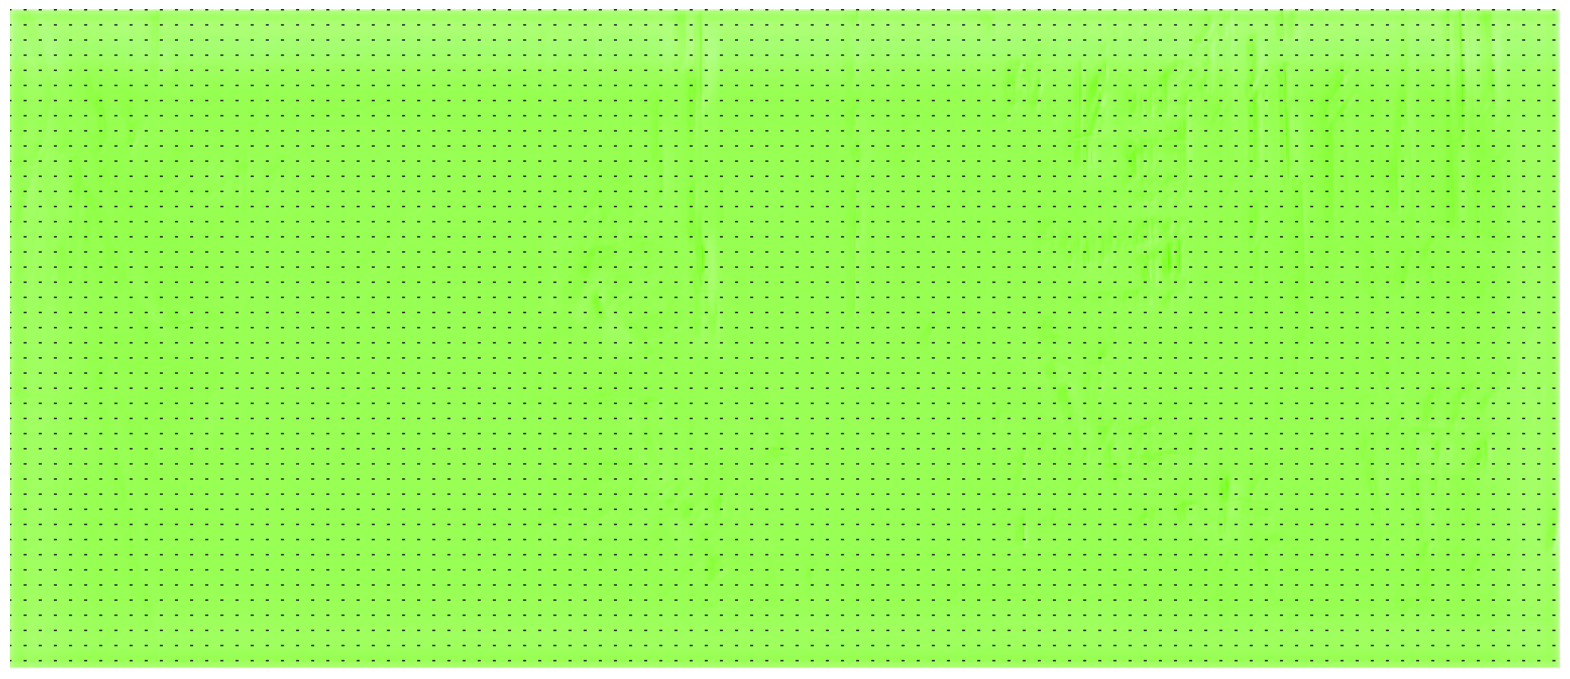

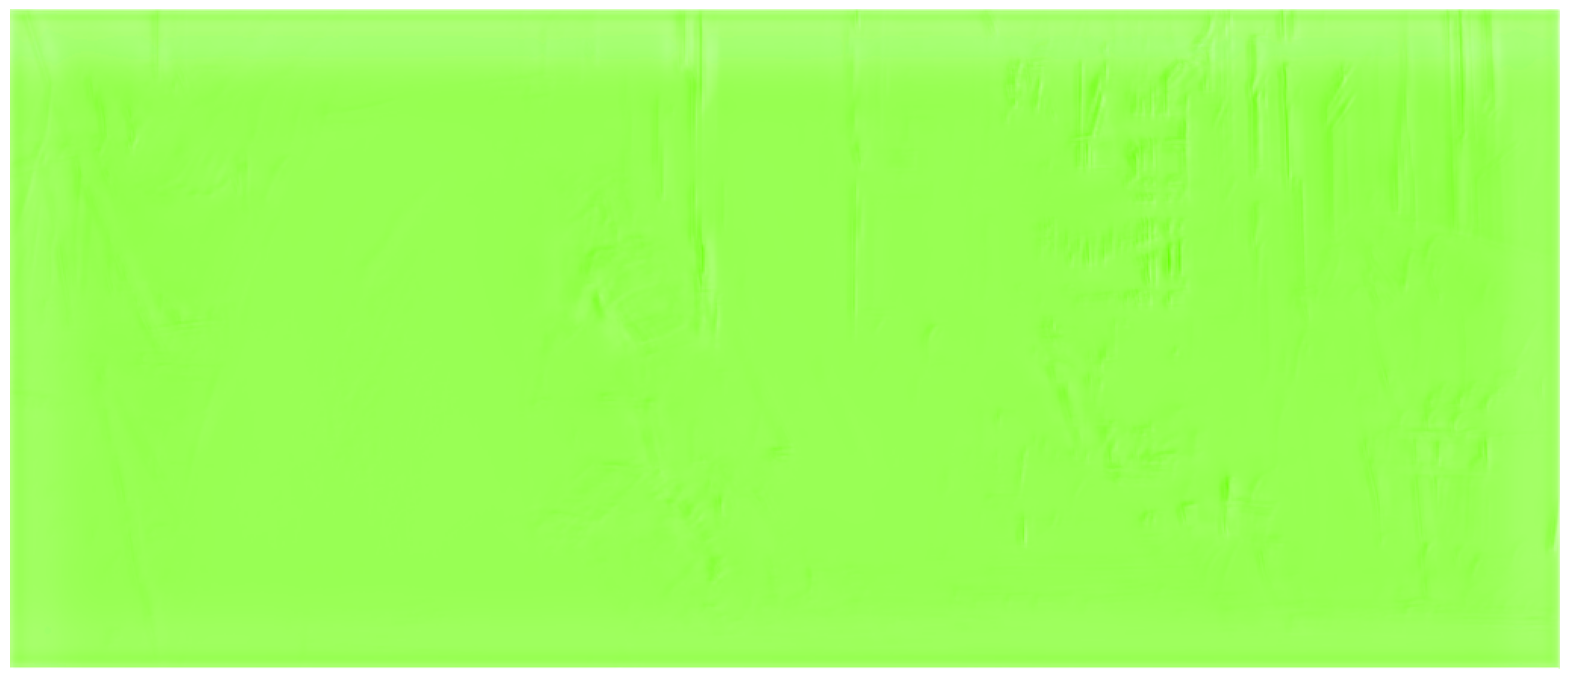

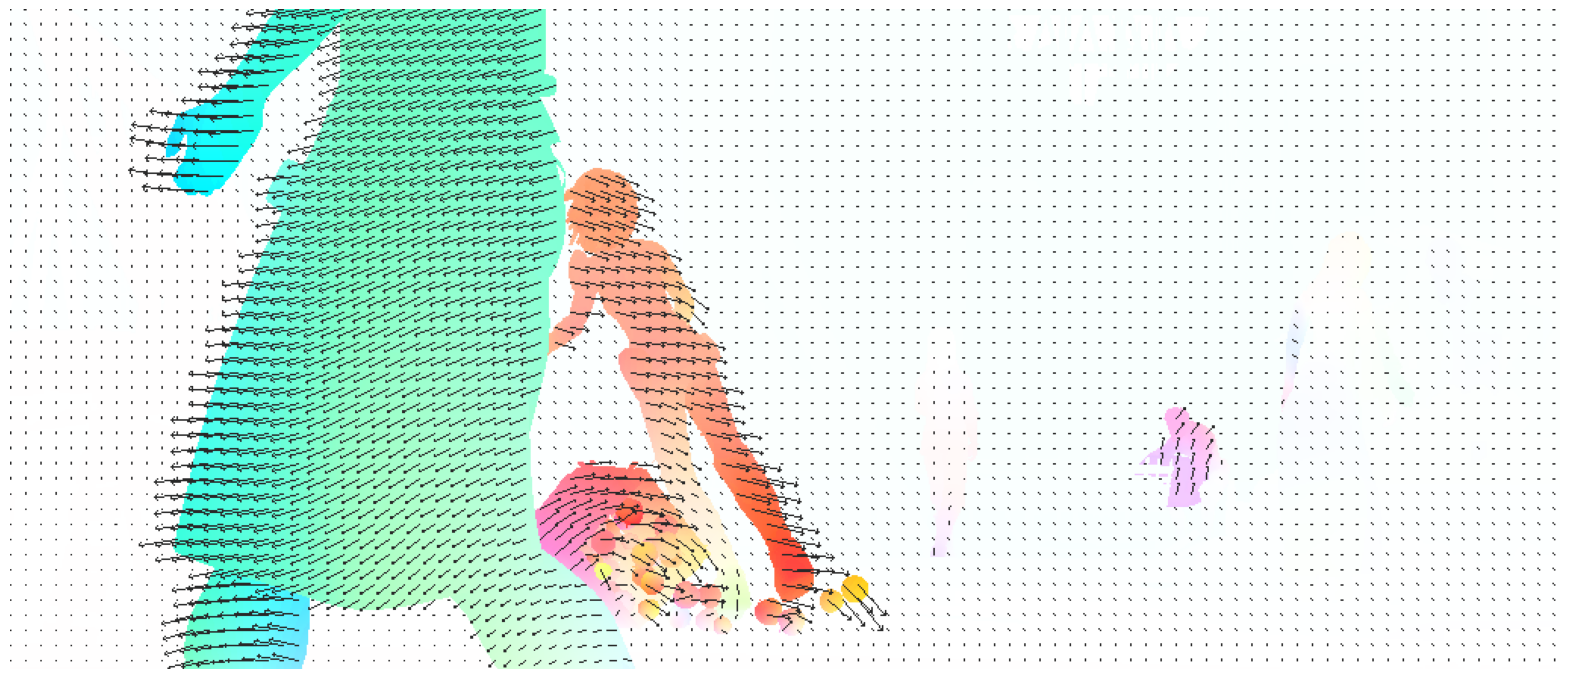

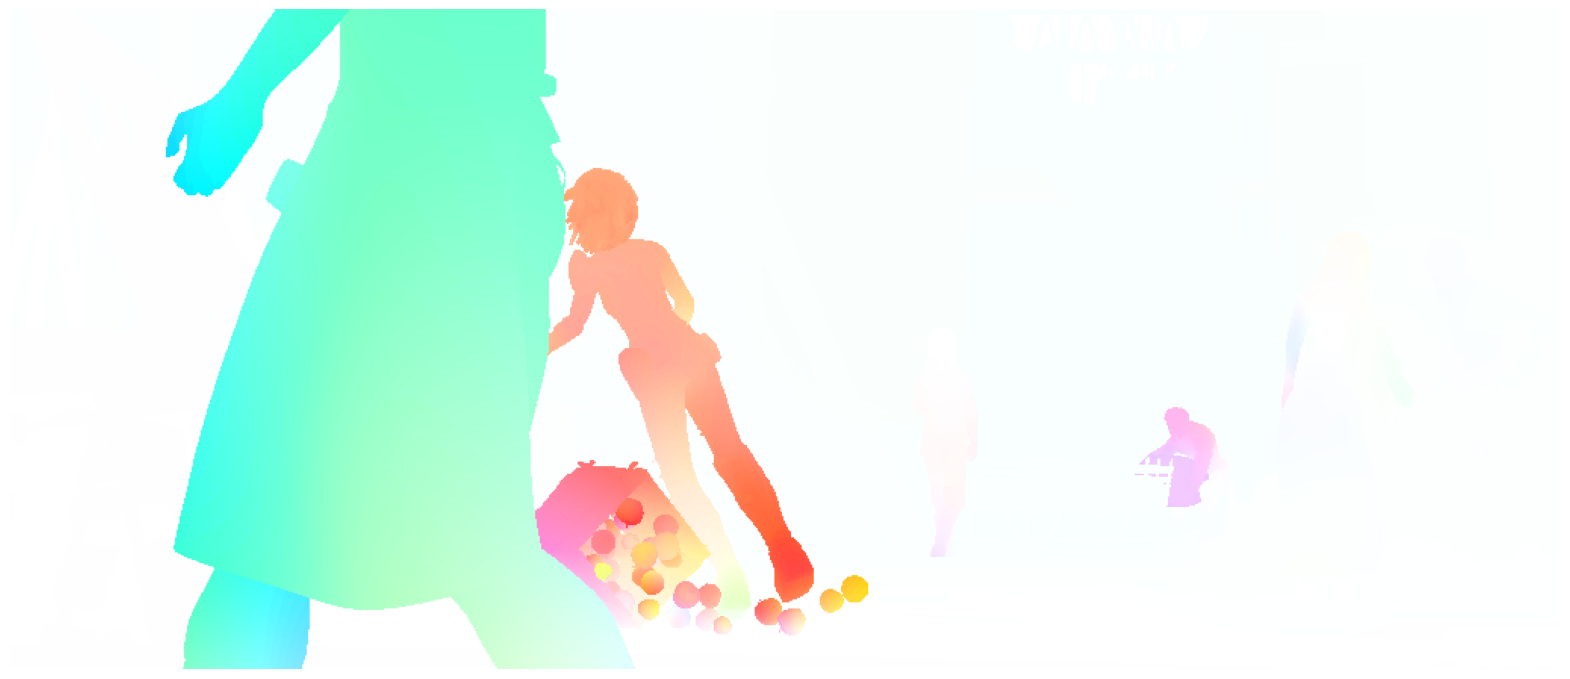

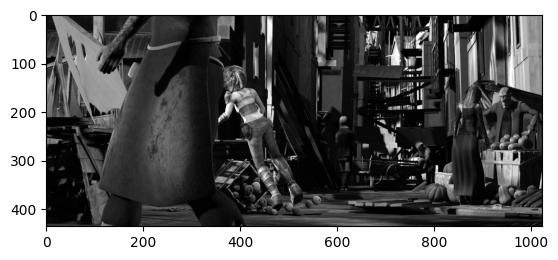

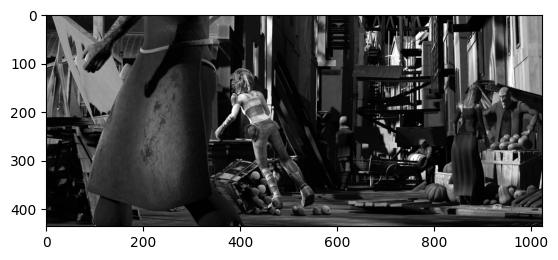

In [20]:
visualiser.visualiseOpticalFlow(result[0].numpy(), drawArrows=True, step=10, scale=1)
visualiser.visualiseOpticalFlow(result[0].numpy(), drawArrows=False, step=10, scale=1)
visualiser.visualiseOpticalFlow(train_y[142], drawArrows=True, step=10, scale = 1)
visualiser.visualiseFlowError(groundTruth=train_y[142], predicted=result[0].numpy())
plt.imshow(imgs[0], cmap = 'gray')
plt.show()
plt.imshow(imgs[1], cmap = 'gray')
plt.show()

In [21]:
SAMPLE_INDEX = 69

images = train_X[SAMPLE_INDEX].numpy()
img1 = images[0]
img2 = images[1]

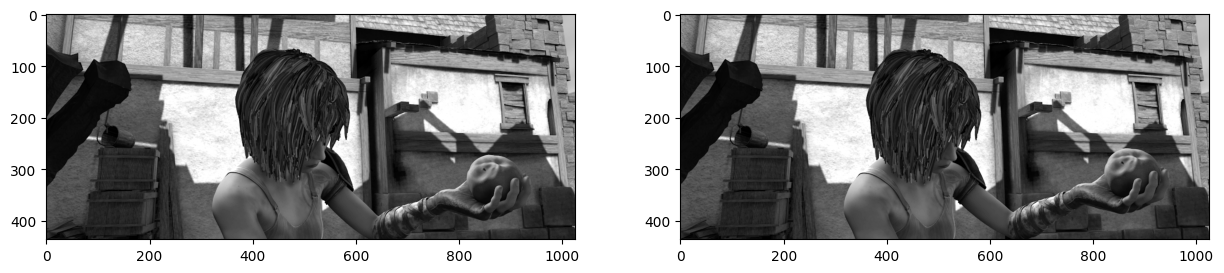

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (15, 30))
ax[0].imshow(img1, cmap='gray')
ax[1].imshow(img2, cmap='gray')
plt.show()

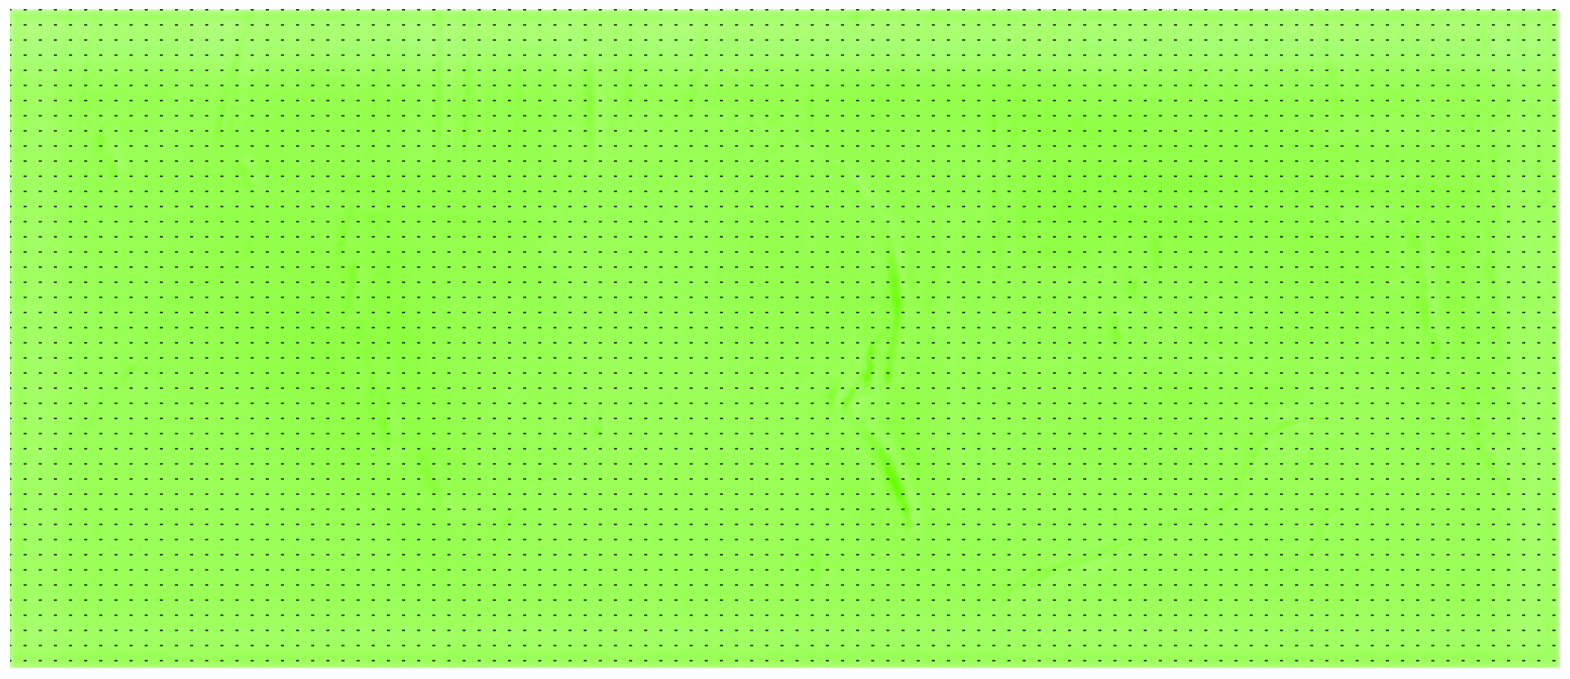

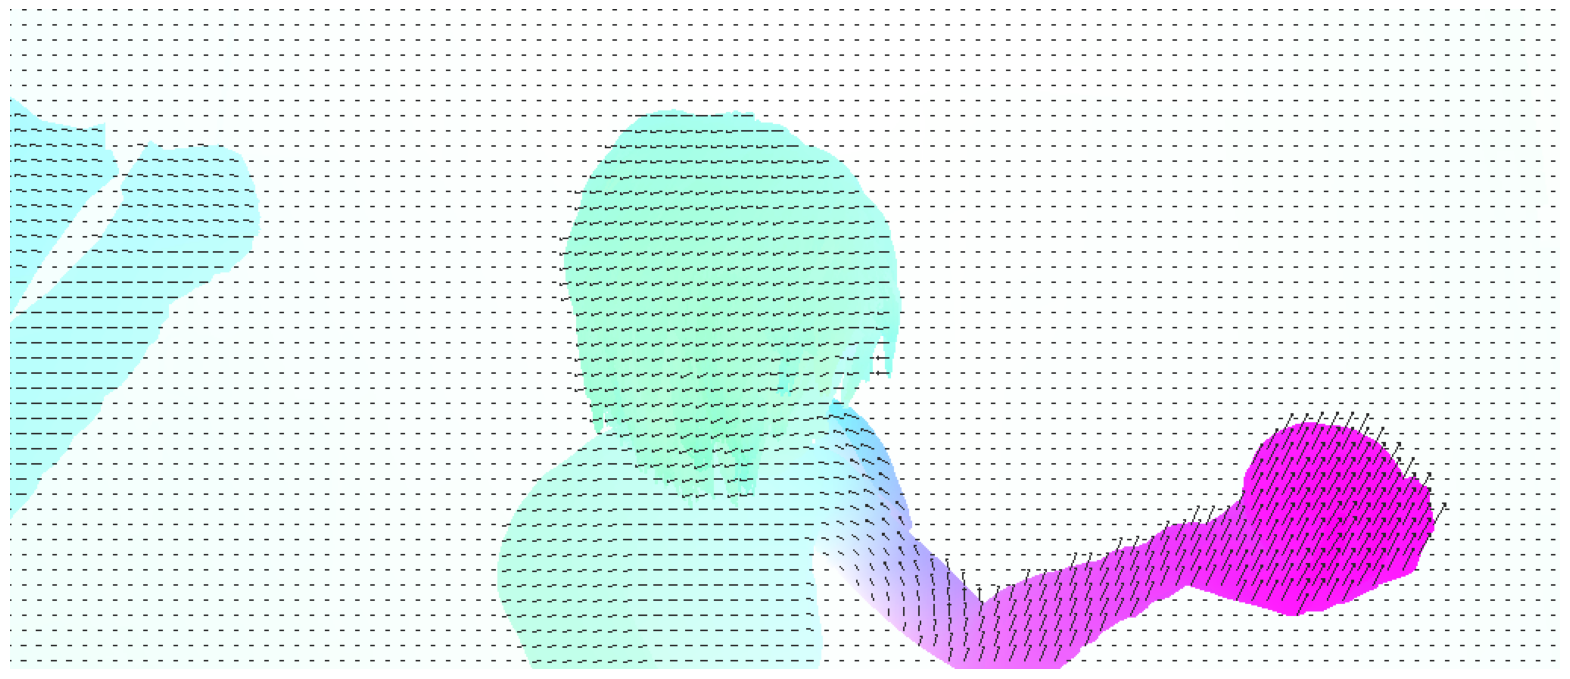

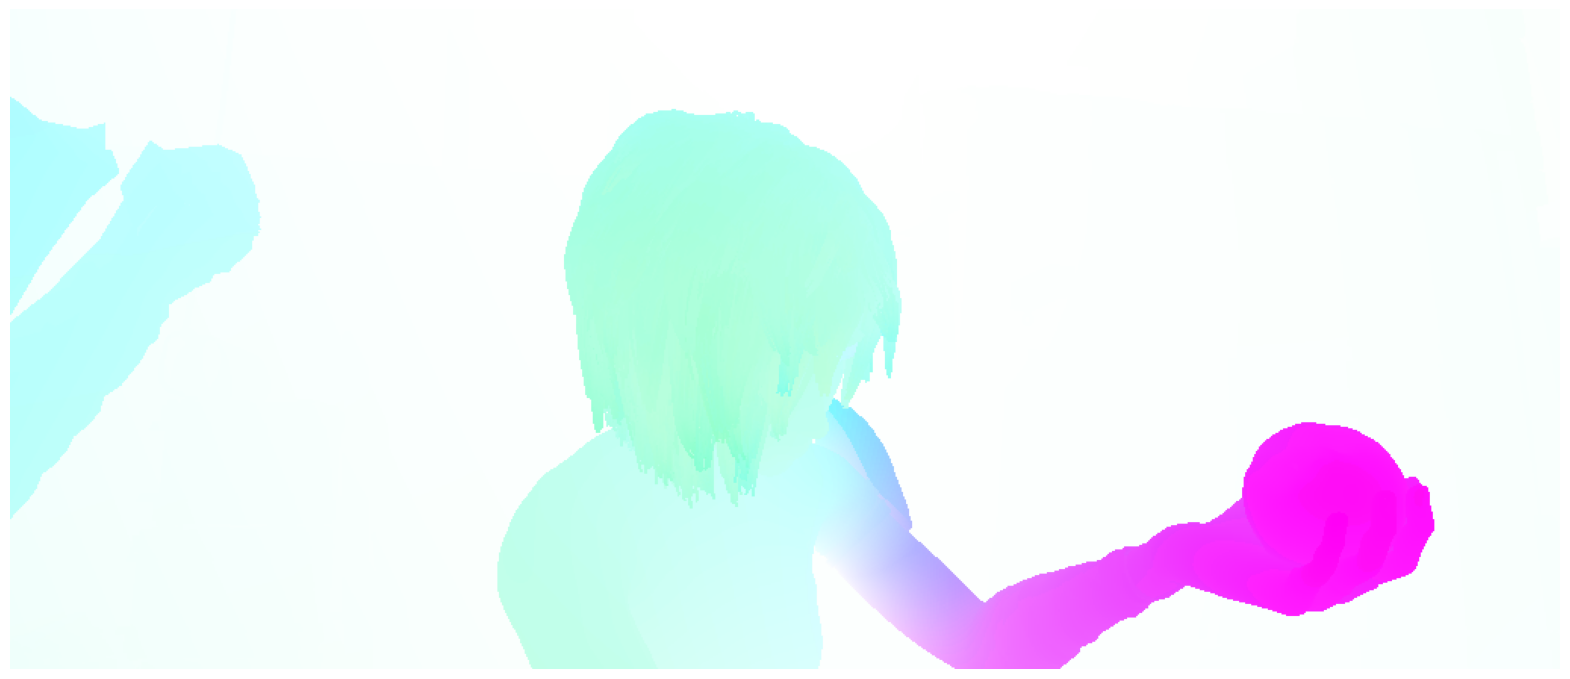

In [23]:
result = model(train_X[SAMPLE_INDEX].numpy().reshape(1, 2, 436, 1024, 1))
visualiser.visualiseOpticalFlow(result[0].numpy(), drawArrows=True, step=10, scale=1)
visualiser.visualiseOpticalFlow(train_y[SAMPLE_INDEX], drawArrows=True, step=10, scale = 1)
visualiser.visualiseFlowError(groundTruth=train_y[SAMPLE_INDEX], predicted=result[0].numpy())

In [28]:
import tensorflow_addons as tfa

warped = tfa.image.dense_image_warp(img2.reshape(1, img2.shape[0], img2.shape[1], img2.shape[2]), -train_y[SAMPLE_INDEX])
warped.shape

TensorShape([1, 436, 1024, 1])

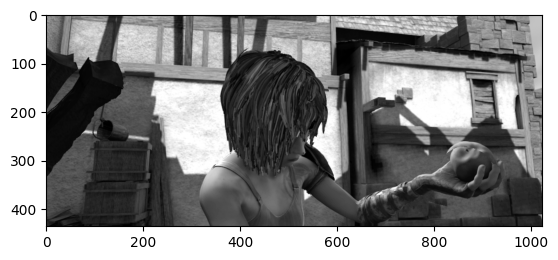

In [29]:
plt.imshow(warped.numpy()[0], cmap = 'gray')

In [40]:
import cv2

def warp_flow(flow, img1=None, img2=None, interpolation=cv2.INTER_LINEAR):
    """Use remap to warp flow, generating a new image. 
Args:
    flow (np.ndarray): flow
    img1 (np.ndarray, optional): previous frame
    img2 (np.ndarray, optional): next frame
Returns:
    warped image
If img1 is input, the output will be img2_warped, but there will be multiple pixels corresponding to a single pixel, resulting in sparse holes. 
If img2 is input, the output will be img1_warped, and there will be no sparse holes. The latter approach is preferred.
    """
    h, w, _ = flow.shape
    remap_flow = flow.transpose(2, 0, 1)
    remap_xy = np.float32(np.mgrid[:h, :w][::-1])
    if img1 is not None:
        uv_new = (remap_xy + remap_flow).round().astype(np.int32)
        mask = (uv_new[0] >= 0) & (uv_new[1] >= 0) & (uv_new[0] < w) & (uv_new[1] < h)
        uv_new_ = uv_new[:, mask]
        remap_xy[:, uv_new_[1], uv_new_[0]] = remap_xy[:, mask]
        remap_x, remap_y = remap_xy
        img2_warped = cv2.remap(img1, remap_x, remap_y, interpolation)
        mask_remaped = np.zeros((h, w), np.bool8)
        mask_remaped[uv_new_[1], uv_new_[0]] = True
        img2_warped[~mask_remaped] = 0
        return img2_warped
    elif img2 is not None:
        remap_x, remap_y = np.float32(remap_xy + remap_flow)
        return cv2.remap(img2, remap_x, remap_y, interpolation)

In [41]:
opencvwarp = warp_flow(flow=train_y[SAMPLE_INDEX], img2=img2)

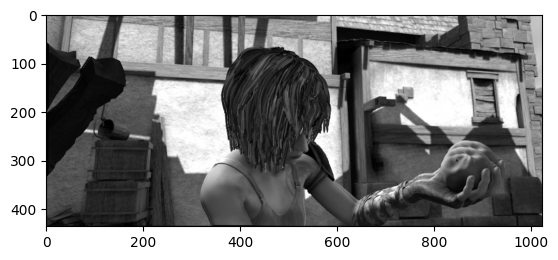

In [42]:
plt.imshow(opencvwarp, cmap='gray')

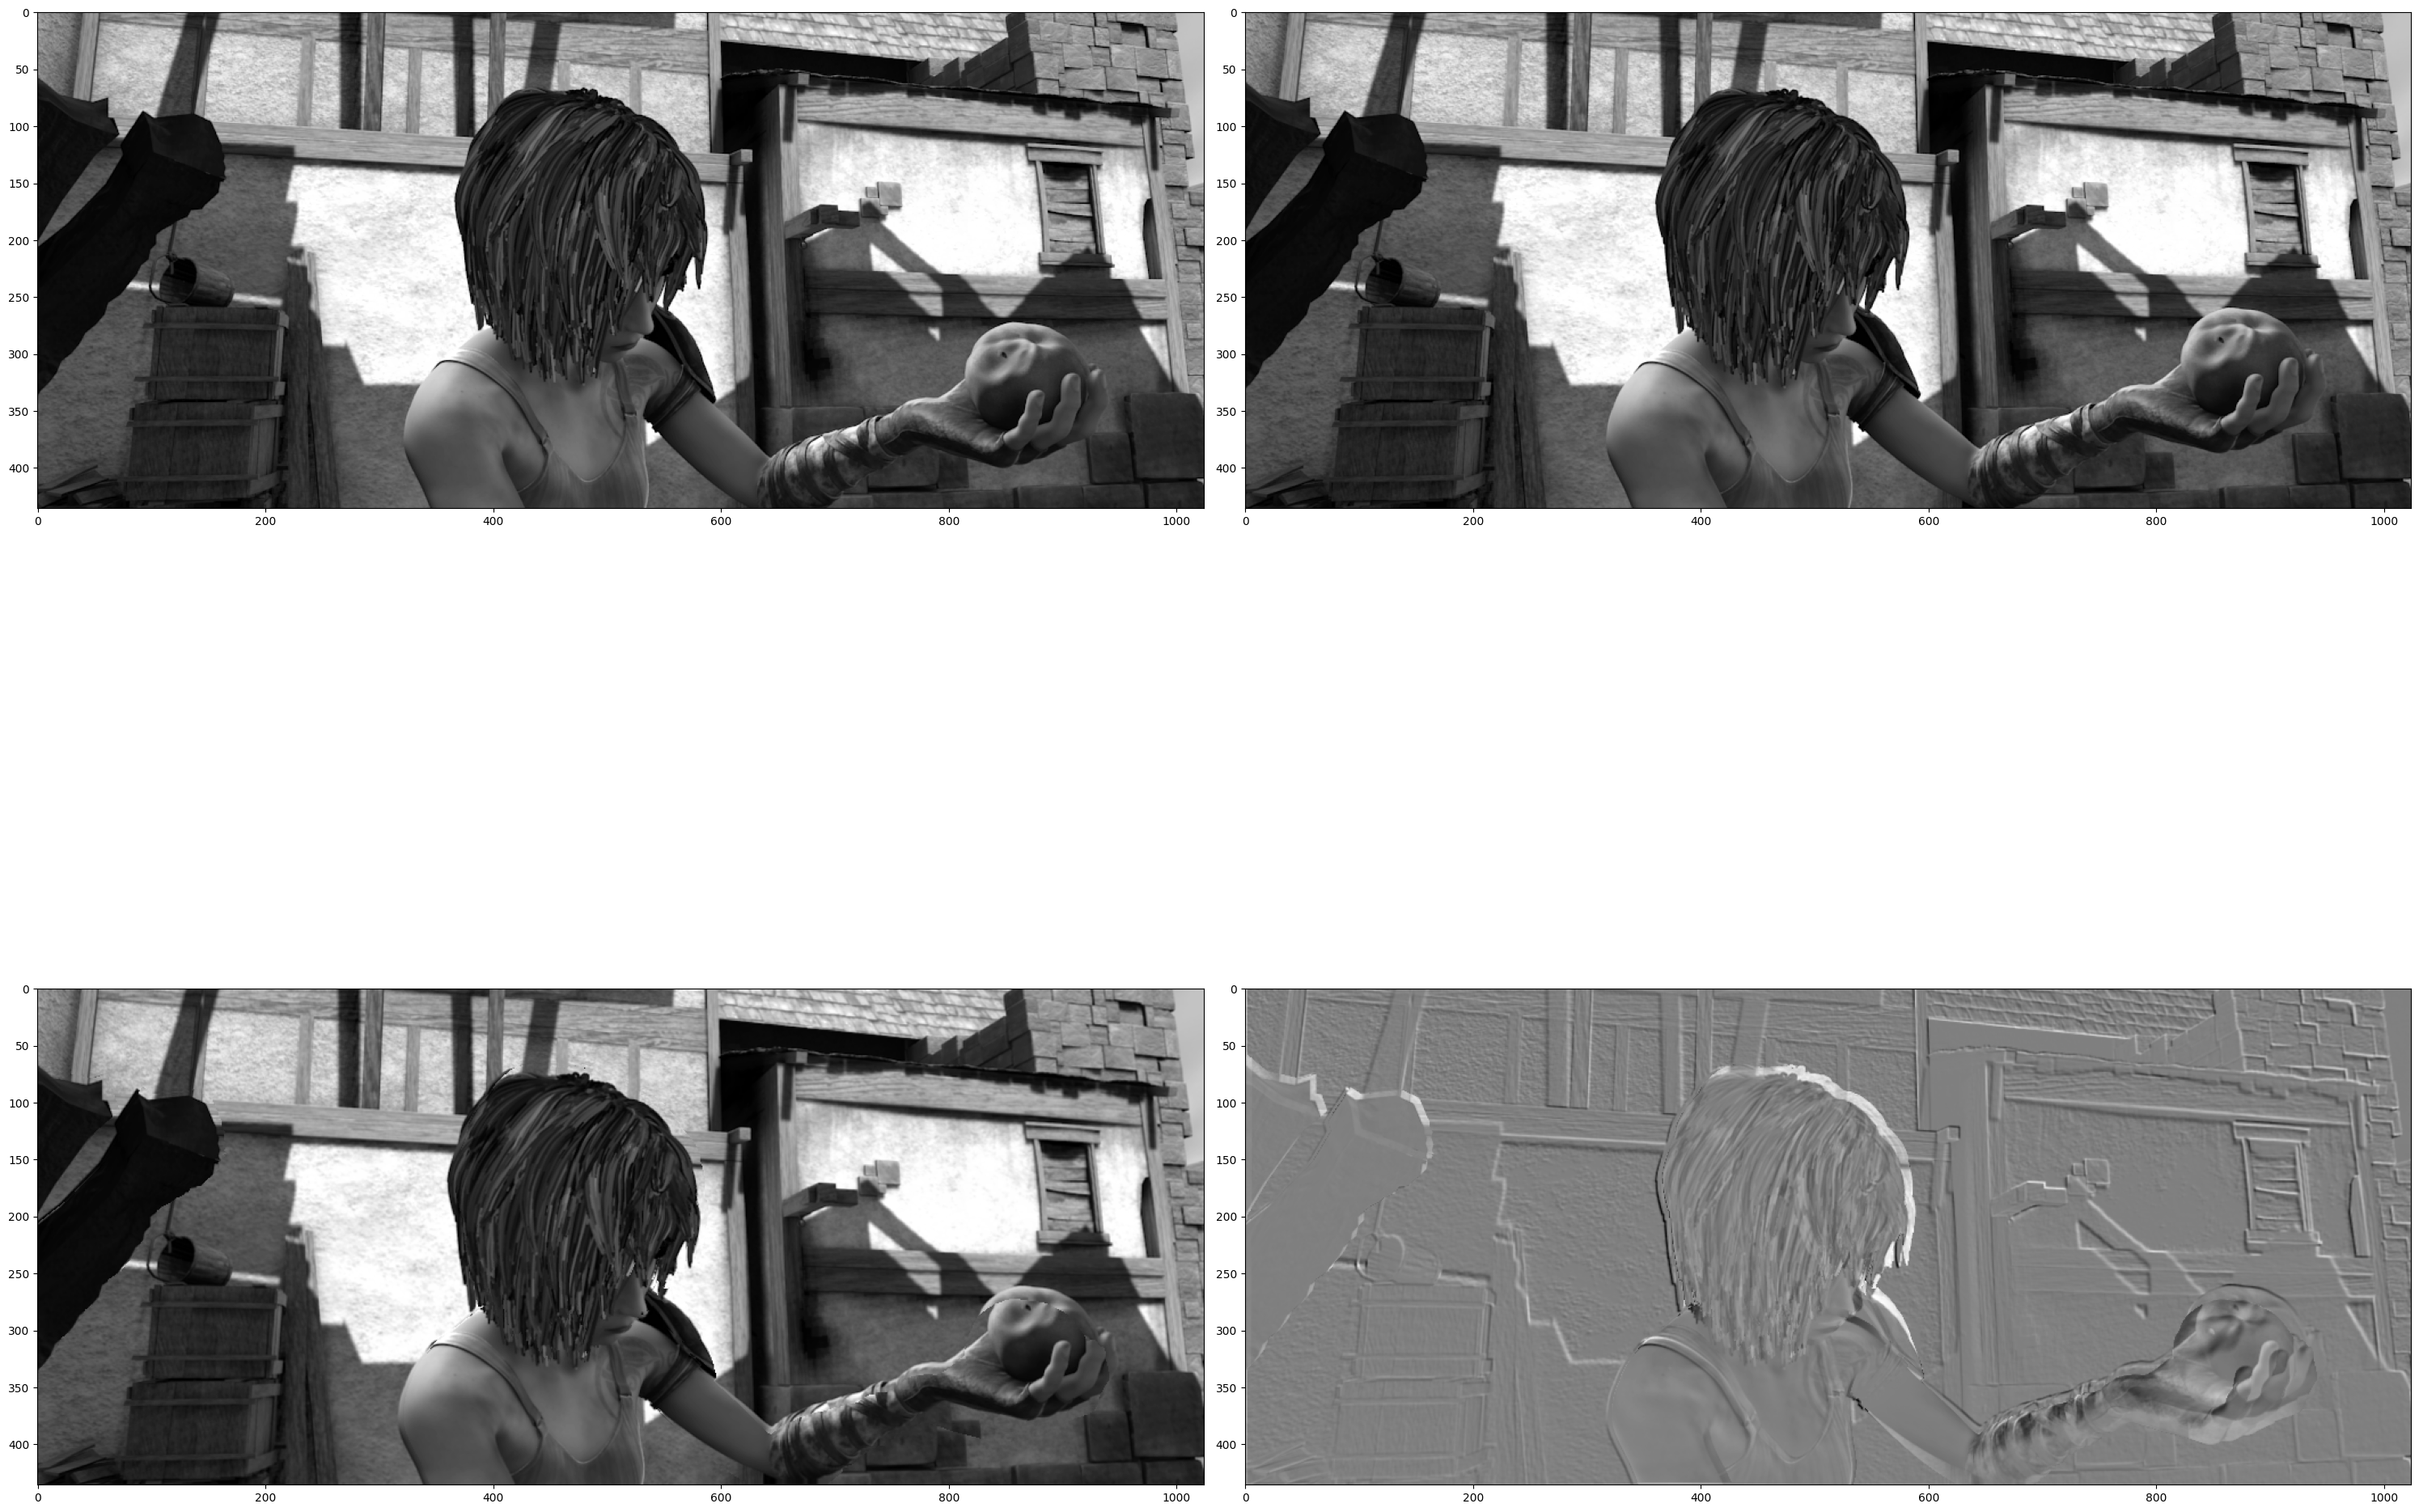

In [43]:
fig, ax = plt.subplots(2, 2, figsize = (30, 30))
ax[0, 0].imshow(img1, cmap='gray')
ax[0, 1].imshow(img2, cmap='gray')
ax[1, 0].imshow(warped.numpy()[0], cmap='gray')
ax[1, 1].imshow(warped.numpy()[0] - opencvwarp.reshape(opencvwarp.shape[0], opencvwarp.shape[1], 1), cmap='gray')

plt.tight_layout()
plt.show()